8792
8968
(17760, 64, 64, 3)


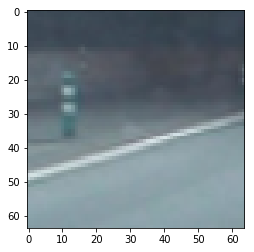

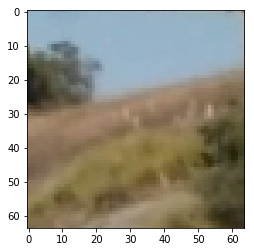

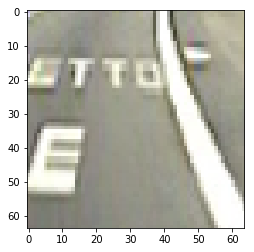

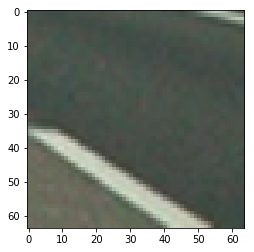

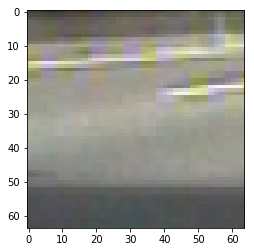

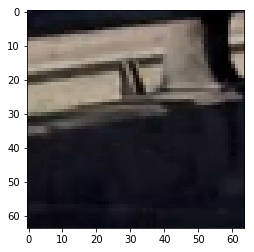

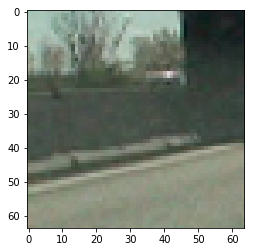

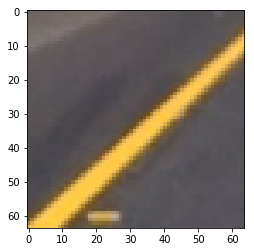

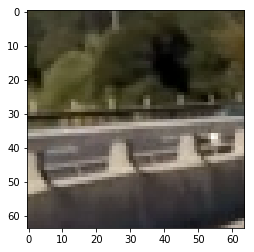

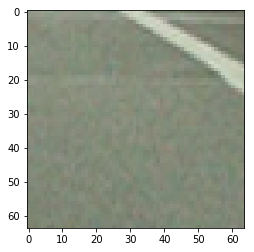

In [26]:
import numpy as np
import pandas as pd
import tensorflow as tf
import scipy.ndimage as nd
import cv2
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import glob
import os
from sklearn.svm import LinearSVC
from sklearn.grid_search import GridSearchCV
import time
# Visualizations will be shown in the notebook.
%matplotlib inline

#Load vehicle data
X = []
y = [] #Label 0 for non-vehicle and Label 1 for vehicle
images_v = []
images_v_src1 = glob.glob('vehicles/GTI_Far/*.png')
images_v_src2 = glob.glob('vehicles/GTI_Left/*.png')
images_v_src3 = glob.glob('vehicles/GTI_MiddleClose/*.png')
images_v_src4 = glob.glob('vehicles/GTI_Right/*.png')
images_v_src5 = glob.glob('vehicles/KITTI_extracted/*.png')

images_v  = images_v_src1 + images_v_src2 + images_v_src3 + images_v_src4 + images_v_src5
random.shuffle(images_v)
print(len(images_v))
for f_img in images_v:
    img = cv2.imread(f_img)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    X.append(img)
    y.append(1)

#Load Non-Vehicle Data
images_nv = []
images_nv_src1 = glob.glob('non-vehicles/Extras/*.png')
images_nv_src2 = glob.glob('non-vehicles/GTI/*.png')

images_nv = images_nv_src1 + images_nv_src2
random.shuffle(images_nv)
print(len(images_nv))
for f_img in images_nv:
    img = cv2.imread(f_img)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    X.append(img)
    y.append(0)


X = np.array(X)
y = np.array(y)
print(X.shape)

X,y = shuffle(X,y)   


In [64]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.hstack((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    boxes = []
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    
    for scale in scales:
        ctrans_tosearch = convert_color(img_tosearch, conv='RGB2LUV')
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
            
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
        nfeat_per_block = orient*cell_per_block**2
        
        
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
        
        
        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
        
        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                
                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell
                
                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                
                hist_features = color_hist(subimg, nbins=hist_bins)
                
                temp = np.hstack((spatial_features, hist_features, hog_features))

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)))   
            
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)
            
                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return boxes,draw_img
    
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [58]:
features_train = []
orient = 11
pix_per_cell = 16
cell_per_block = 2
spatial_size = 32
hist_bins = 32

#Extract features for all the training images
for i in range(0,X.shape[0]):
    img = convert_color(X[i], conv='RGB2LUV')
    #Collect Hog-features channel wise
    hog_ch1 = get_hog_features(img[:,:,0], orient, pix_per_cell, cell_per_block,vis=False, feature_vec=False).ravel()
    hog_ch2 = get_hog_features(img[:,:,1], orient, pix_per_cell, cell_per_block,vis=False, feature_vec=False).ravel()
    hog_ch3 = get_hog_features(img[:,:,2], orient, pix_per_cell, cell_per_block,vis=False, feature_vec=False).ravel()
    
    hog_feat = np.hstack((hog_ch1,hog_ch2,hog_ch3))
    
    #Collect Spatial binned features and Histogram bin features
    spatial_features = bin_spatial(img)
    hist_features = color_hist(img)
    
    features = np.hstack((spatial_features,hist_features,hog_feat)).reshape(1,-1)
    features_train.append(list(features))

#Standard scaling of all the features
features_train = np.array(features_train)
features_train = np.squeeze(features_train)
print(features_train.shape)

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(features_train, y, test_size=0.2, random_state=22)

X_scaler = StandardScaler().fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

svc = LinearSVC(loss='hinge') # Use a linear SVC 
t=time.time() # Check the training time for the SVC
svc.fit(X_train, y_train) # Train the classifier
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4)) # Check the score of the SVC


"""
features_train = np.squeeze(features_train)
X_scaler = StandardScaler().fit(features_train)
features_train = X_scaler.transform(features_train)
print("Features extracted and scaled for training")

#SVM kernel
#parameters = {'kernel':('linear', 'rbf'), 'C':[0.1, 1, 10]}
svr = LinearSVC(C=0.01)
#clf = GridSearchCV(svr, parameters)
svr.fit(features_train, y_train)
print("Training done")
"""



/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


(17760, 4356)
5.17 Seconds to train SVC...
Test Accuracy of SVC =  0.9947


'\nfeatures_train = np.squeeze(features_train)\nX_scaler = StandardScaler().fit(features_train)\nfeatures_train = X_scaler.transform(features_train)\nprint("Features extracted and scaled for training")\n\n#SVM kernel\n#parameters = {\'kernel\':(\'linear\', \'rbf\'), \'C\':[0.1, 1, 10]}\nsvr = LinearSVC(C=0.01)\n#clf = GridSearchCV(svr, parameters)\nsvr.fit(features_train, y_train)\nprint("Training done")\n'

847
1014
1169
985
891
768


"\n# Fit a per-column scaler\nX_scaler = StandardScaler().fit(X_train)\n# Apply the scaler to X\nX_train = X_scaler.transform(X_train)\nX_test = X_scaler.transform(X_test)\n\n#SVM kernel\nparameters = {'kernel':('linear', 'rbf'), 'C':[0,1, 1, 10]}\nsvr = svm.SVC()\nclf = grid_search.GridSearchCV(svr, parameters)\nclf.fit(X_train, y_train)\n\nimages_test = glob.glob('CarND-Vehicle-Detection/test_images/*.jpg')\nfor f_img in images_v:\n    img = cv2.imread(f_img)\n    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)\n    img = convert_color(img, conv='RGB2YCrCb')\n    #Collect Hog-features channel wise\n    hog_ch1 = get_hog_features(img, orient, pix_per_cell, cell_per_block, \n                        vis=False, feature_vec=False)\n\n\nboxes = find_cars(img, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)\n\nheat = np.zeros_like(image[:,:,0]).astype(np.float)\n# Add heat to each box in box list\nheat = add_heat(heat,box_list)\n    \n# Apply th

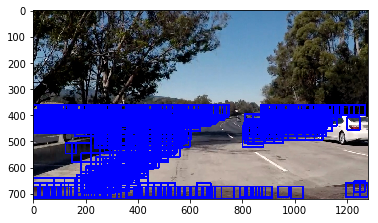

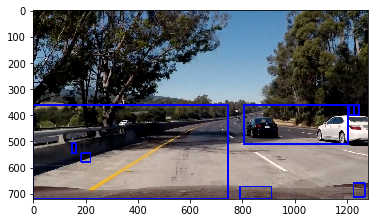

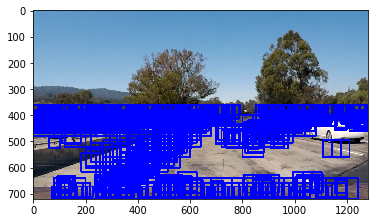

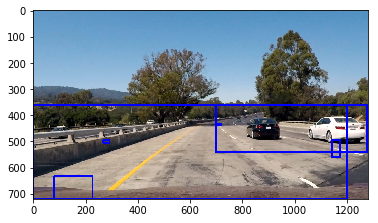

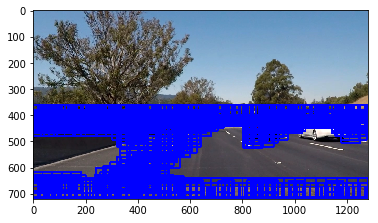

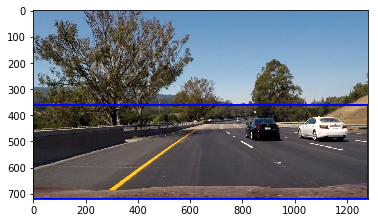

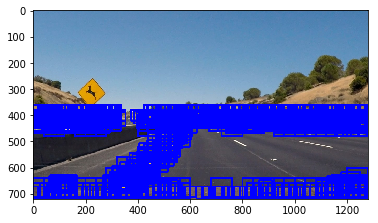

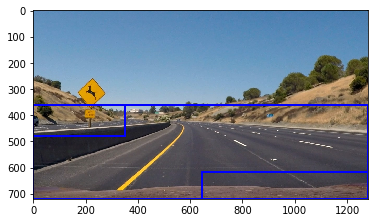

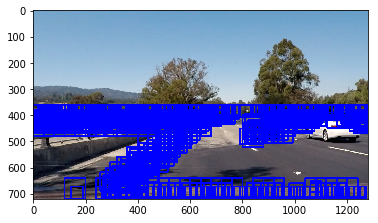

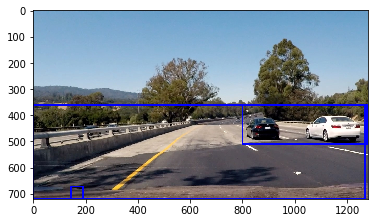

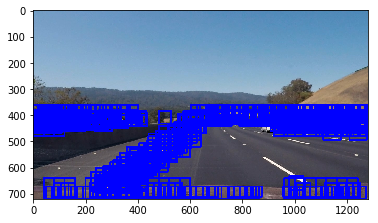

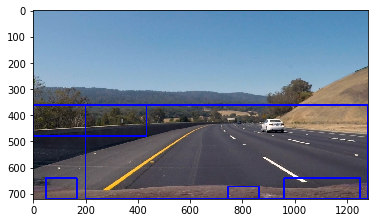

In [65]:
from scipy.ndimage.measurements import label
import warnings
warnings.filterwarnings('ignore')


#Operations on test-images
scales = [0.65,0.75,0.85,0.95,1.05,1.15,1.25]
images_test = glob.glob('test_images/*.jpg')
for f_img in images_test:
    img = cv2.imread(f_img)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    ystart = np.int(img.shape[0]/2)
    ystop = img.shape[0]
    boxes,rect_img = find_cars(img, ystart, ystop, scales, svr, X_scaler, orient, pix_per_cell, cell_per_block, (spatial_size,spatial_size), hist_bins)
    
    print(len(boxes))
    plt.imshow(rect_img)
    plt.figure()
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat,boxes)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)
    
    # Visualize the heatmap when displaying
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    plt.imshow(draw_img)
    plt.figure()
    


"""
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

#SVM kernel
parameters = {'kernel':('linear', 'rbf'), 'C':[0,1, 1, 10]}
svr = svm.SVC()
clf = grid_search.GridSearchCV(svr, parameters)
clf.fit(X_train, y_train)

images_test = glob.glob('CarND-Vehicle-Detection/test_images/*.jpg')
for f_img in images_v:
    img = cv2.imread(f_img)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = convert_color(img, conv='RGB2YCrCb')
    #Collect Hog-features channel wise
    hog_ch1 = get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=False)


boxes = find_cars(img, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

heat = np.zeros_like(image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)
"""
